In [2]:
import numpy as np
import pandas as pd

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import plot_model
from PIL import Image

In [3]:
train_directory="chest_xray/train/"
val_directory="chest_xray/val/"
test_directory="chest_xray/test/"

In [4]:
data_dir = train_directory
class_names=os.listdir(train_directory)
class_names.pop()
print(class_names)

['PNEUMONIA']


In [5]:
def view_random_image(target_directory, target_class):
    target_folder = target_directory + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

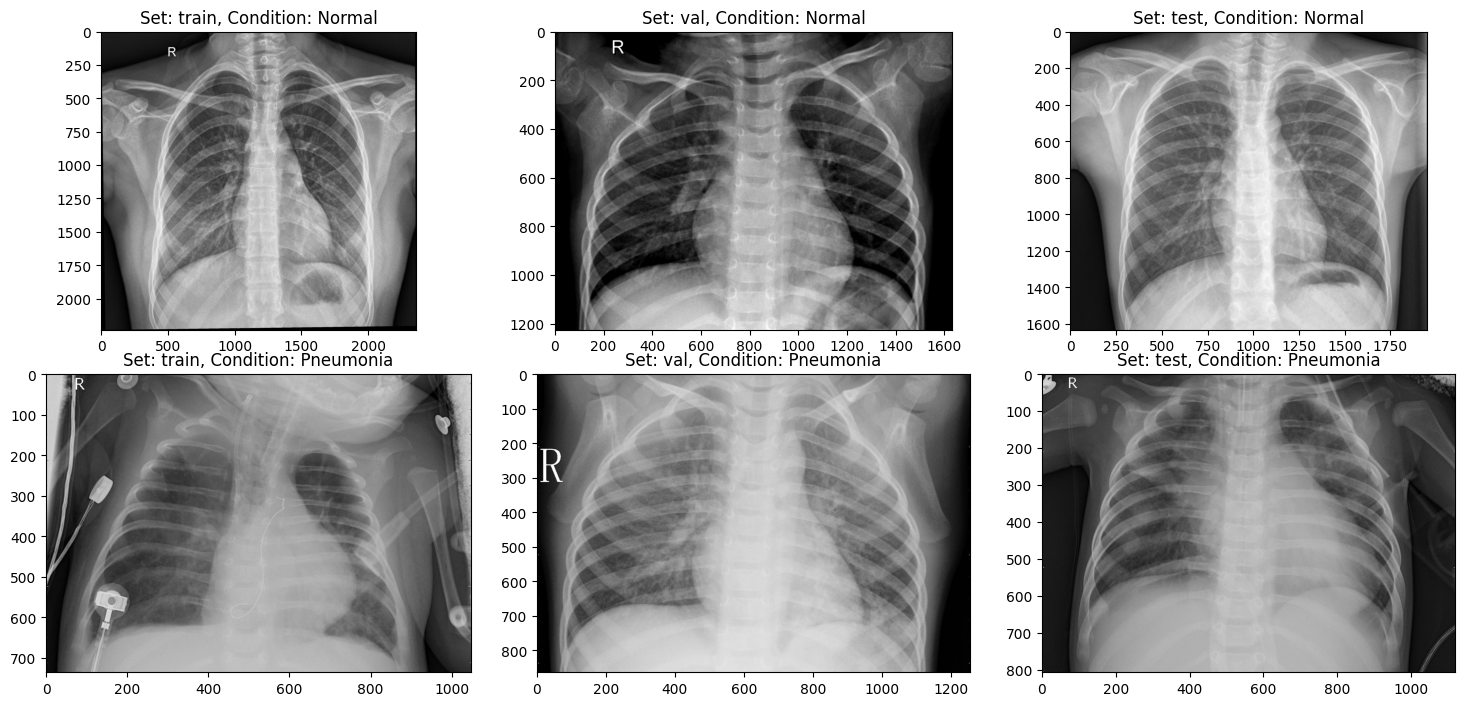

In [6]:
input_path="chest_xray/"
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [7]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3876
Set: val, Normal images: 8, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


In [8]:
# Re-sizing the images
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32

CNN:

In [9]:
from skimage import exposure

# Define a custom preprocessing function for histogram equalization
def histogram_equalization_preprocessing(image):
    # Apply histogram equalization using skimage's exposure module
    # Since the images are grayscale, directly apply equalization
    enhanced_image = exposure.equalize_hist(image)
    
    return enhanced_image

In [10]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest',
        preprocessing_function=histogram_equalization_preprocessing
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255,
        preprocessing_function=histogram_equalization_preprocessing
)

In [11]:
train = Image_gen.flow_from_directory(train_directory,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = Image_gen.flow_from_directory(val_directory,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_directory,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
img, label = next(train)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [14]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

In [15]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [16]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
res_model = create_model()

In [17]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

Resnet

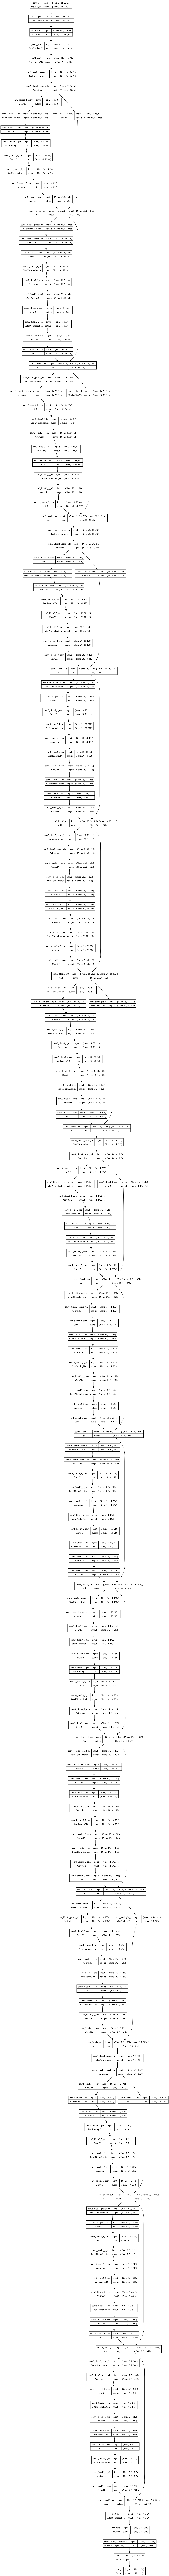

In [18]:
plot_model(res_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

In [19]:
history = res_model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 132s 1s/step - loss: 0.5616 - accuracy: 0.7403 - val_loss: 0.7369 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 139s 1s/step - loss: 0.5297 - accuracy: 0.7484 - val_loss: 0.8375 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 148s 1s/step - loss: 0.5201 - accuracy: 0.7500 - val_loss: 0.9698 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 145s 1s/step - loss: 0.5082 - accuracy: 0.7534 - val_loss: 0.9052 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 3360s 34s/step - loss: 0.5033 - accuracy: 0.7575 - val_loss: 1.0449 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 150s 2s/step - loss: 0.4962 - accuracy: 0.7638 - val_loss: 0.9949 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 144s 1s/

Text(0, 0.5, 'Loss')

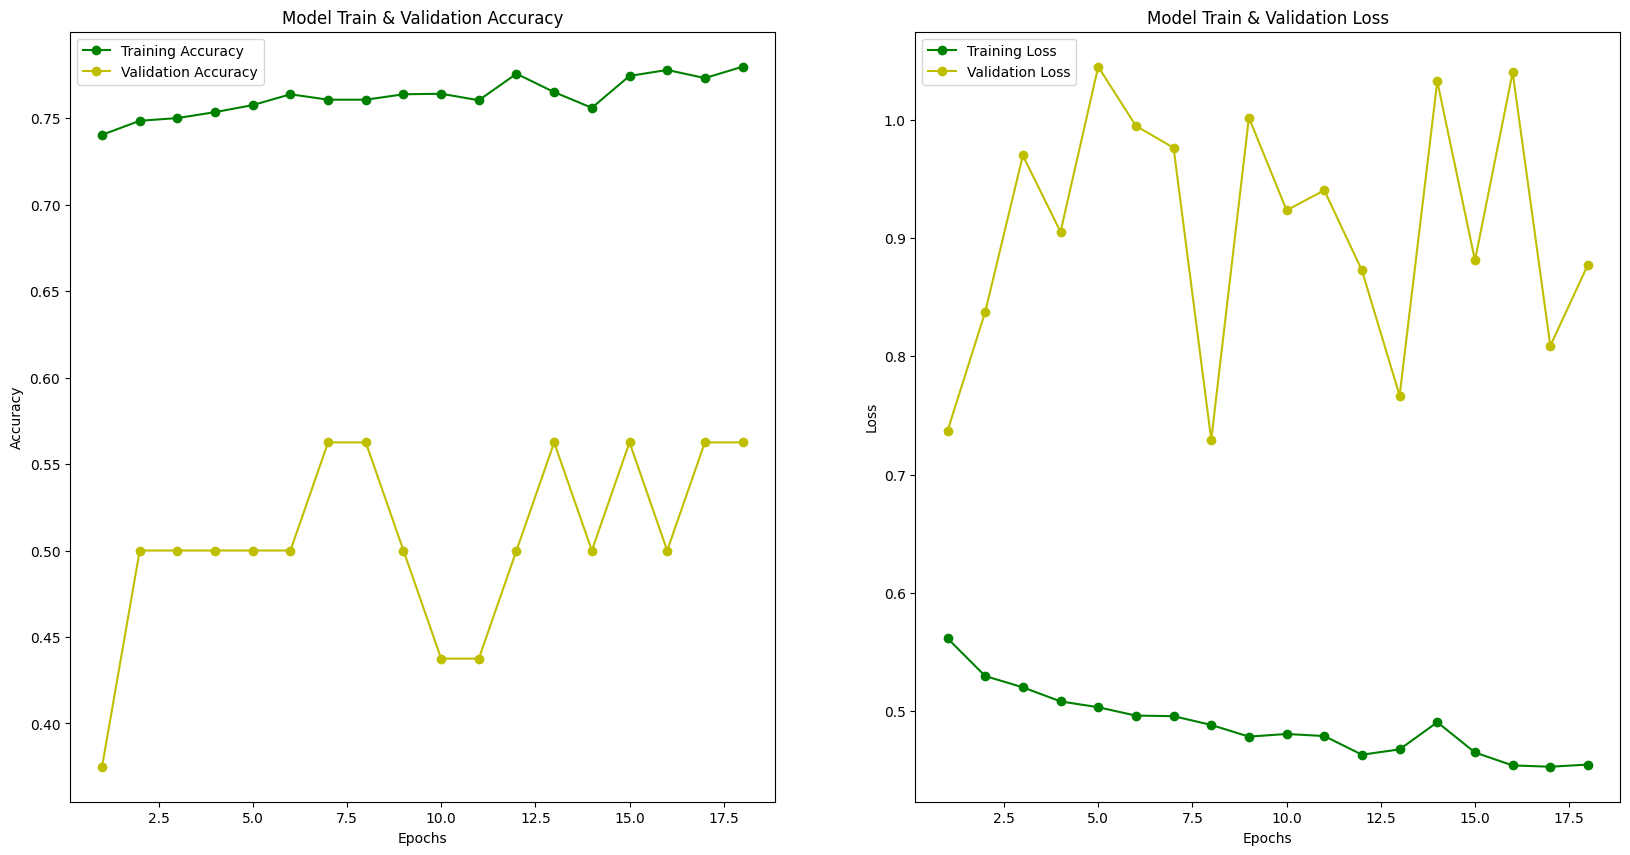

In [20]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

In [21]:
train_score = res_model.evaluate(train)
validation_score = res_model.evaluate(validation)
test_score = res_model.evaluate(test)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])

print("\nValidation Loss: ", validation_score[0])
print("Validation Accuracy: ", validation_score[1])

print("\nTest loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

312/312 [==============================] - 39s 125ms/step - loss: 0.4760 - accuracy: 0.7292
Train Loss:  0.4446791708469391
Train Accuracy:  0.776648759841919

Validation Loss:  0.9542754888534546
Validation Accuracy:  0.5625

Test loss:  0.47596505284309387
Test Accuracy:  0.7291666865348816
